# 🎸 Guitar Pattern Generation - LSTM Training Notebook

**Author:** Rohan Rajendra Dhanawade  
**Project:** Master's Thesis - SRH Berlin University of Applied Sciences  
**Title:** A Conversational AI System for Symbolic Guitar Strumming Pattern and Chord Progression Generation

---

## What This Notebook Does

This notebook trains an LSTM model to generate guitar chord progressions and strumming patterns from natural language descriptions.

**Steps:**
1. Install dependencies
2. Mount Google Drive for saving checkpoints
3. Load the dataset (129 training samples)
4. Train the LSTM model (~1.08M parameters)
5. Evaluate and generate samples
6. Save the trained model

**Expected Training Time:** ~5-15 minutes on GPU (T4/V100)

---
## 📦 Cell 1: Setup & Installation

In [ ]:
# Install required packages (if not already installed)
!pip install torch torchvision torchaudio --quiet
!pip install matplotlib seaborn pandas --quiet

print("✅ Dependencies installed!")

✅ Dependencies installed!


---
## 📁 Cell 2: Mount Google Drive

This allows us to save checkpoints that persist even after the Colab session ends.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Create a directory for this project
import os
PROJECT_DIR = '/content/drive/MyDrive/guitar_thesis'
CHECKPOINT_DIR = f'{PROJECT_DIR}/checkpoints'
DATA_DIR = f'{PROJECT_DIR}/data'

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

print(f"✅ Google Drive mounted!")
print(f"📂 Project directory: {PROJECT_DIR}")
print(f"📂 Checkpoints will be saved to: {CHECKPOINT_DIR}")

Mounted at /content/drive
✅ Google Drive mounted!
📂 Project directory: /content/drive/MyDrive/guitar_thesis
📂 Checkpoints will be saved to: /content/drive/MyDrive/guitar_thesis/checkpoints


---
## 🔍 Cell 3: Verify GPU

Make sure you have GPU enabled: **Runtime → Change runtime type → GPU**

In [ ]:
import torch

# Check GPU availability
if torch.cuda.is_available():
    device = torch.device('cuda')
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU Available: {gpu_name}")
    print(f"   Memory: {gpu_memory:.1f} GB")
else:
    device = torch.device('cpu')
    print("⚠️ No GPU found! Training will be slower.")
    print("   Go to Runtime → Change runtime type → GPU")

print(f"\n🔧 Using device: {device}")
print(f"📦 PyTorch version: {torch.__version__}")

✅ GPU Available: Tesla T4
   Memory: 15.8 GB

🔧 Using device: cuda
📦 PyTorch version: 2.9.0+cu126


---
## 📤 Cell 4: Upload Data Files

Upload your JSONL data files. You have two options:

**Option A:** Upload directly (run the cell below)  
**Option B:** Copy files from Google Drive (if you've already uploaded them)

In [ ]:
# Option A: Upload files directly
from google.colab import files
import shutil

print("📤 Please upload your data files:")
print("   - train.jsonl")
print("   - val.jsonl")
print("   - test.jsonl (optional)")
print("")

uploaded = files.upload()

# Move to data directory
for filename in uploaded.keys():
    shutil.move(filename, f'{DATA_DIR}/{filename}')
    print(f"✅ Moved {filename} to {DATA_DIR}")

# List files
print(f"\n📂 Files in {DATA_DIR}:")
for f in os.listdir(DATA_DIR):
    print(f"   - {f}")

📤 Please upload your data files:
   - train.jsonl
   - val.jsonl
   - test.jsonl (optional)



Saving test.jsonl to test.jsonl
Saving train.jsonl to train.jsonl
Saving val.jsonl to val.jsonl
✅ Moved test.jsonl to /content/drive/MyDrive/guitar_thesis/data
✅ Moved train.jsonl to /content/drive/MyDrive/guitar_thesis/data
✅ Moved val.jsonl to /content/drive/MyDrive/guitar_thesis/data

📂 Files in /content/drive/MyDrive/guitar_thesis/data:
   - toy
   - test.jsonl
   - train.jsonl
   - val.jsonl


In [ ]:
# Option B: If files are already in Google Drive, set paths here
# Uncomment and modify if needed:

# TRAIN_PATH = f'{DATA_DIR}/train.jsonl'
# VAL_PATH = f'{DATA_DIR}/val.jsonl'
# TEST_PATH = f'{DATA_DIR}/test.jsonl'

# Verify files exist
TRAIN_PATH = f'{DATA_DIR}/train.jsonl'
VAL_PATH = f'{DATA_DIR}/val.jsonl'
TEST_PATH = f'{DATA_DIR}/test.jsonl'

for path in [TRAIN_PATH, VAL_PATH]:
    if os.path.exists(path):
        print(f"✅ Found: {path}")
    else:
        print(f"❌ Missing: {path}")

✅ Found: /content/drive/MyDrive/guitar_thesis/data/train.jsonl
✅ Found: /content/drive/MyDrive/guitar_thesis/data/val.jsonl


---
## 🧩 Cell 5: Define All Model Components

This cell contains all the code for:
- Tokenizer
- Feature Encoder  
- LSTM Model
- Dataset
- Trainer

*(In production, these would be imported from separate files)*

In [ ]:
# ============================================================================
# TOKENIZER
# ============================================================================

from typing import Dict, List, Optional, Tuple, Union

# Vocabulary: 36 tokens total
VOCABULARY = {
    # Special tokens (0-3)
    "<PAD>": 0, "<BOS>": 1, "<EOS>": 2, "<SEP>": 3,
    # Chords (4-32)
    "C": 4, "D": 5, "E": 6, "F": 7, "G": 8, "A": 9, "B": 10,
    "A#": 11, "C#": 12, "D#": 13, "G#": 14,
    "Am": 15, "Bm": 16, "Cm": 17, "Dm": 18, "Em": 19, "Fm": 20, "Gm": 21,
    "A#m": 22, "C#m": 23, "F#m": 24, "G#m": 25,
    "A7": 26, "B7": 27, "D7": 28, "E7": 29,
    "Asus4": 30, "C#dim": 31, "Gdim": 32,
    # Strumming characters (33-35)
    "D_strum": 33, "U_strum": 34, "_rest": 35,
}

ID_TO_TOKEN = {v: k for k, v in VOCABULARY.items()}
VOCAB_SIZE = len(VOCABULARY)
MAX_SEQ_LENGTH = 20

class MusicTokenizer:
    """Tokenizer for guitar chord progressions and strumming patterns."""

    def __init__(self, max_seq_length: int = MAX_SEQ_LENGTH):
        self.vocab = VOCABULARY
        self.id_to_token = ID_TO_TOKEN
        self.max_seq_length = max_seq_length
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2
        self.sep_id = 3

    def encode(self, chords: List[str], strum_pattern: str,
               add_special_tokens: bool = True,
               pad_to_max_length: bool = True) -> List[int]:
        token_ids = []

        if add_special_tokens:
            token_ids.append(self.bos_id)

        # Encode chords
        for chord in chords:
            if chord in self.vocab:
                token_ids.append(self.vocab[chord])

        if add_special_tokens:
            token_ids.append(self.sep_id)

        # Encode strumming pattern
        for char in strum_pattern:
            if char == 'D':
                token_ids.append(self.vocab["D_strum"])
            elif char == 'U':
                token_ids.append(self.vocab["U_strum"])
            elif char == '_':
                token_ids.append(self.vocab["_rest"])

        if add_special_tokens:
            token_ids.append(self.eos_id)

        if pad_to_max_length:
            token_ids = self.pad_sequence(token_ids)

        return token_ids

    def decode(self, token_ids: List[int]) -> Tuple[List[str], str]:
        chords = []
        strum_chars = []
        seen_sep = False

        for tid in token_ids:
            if tid in [self.pad_id, self.bos_id, self.eos_id]:
                continue
            if tid == self.sep_id:
                seen_sep = True
                continue

            token = self.id_to_token.get(tid, "")

            if not seen_sep:
                if token and not token.endswith("_strum") and token != "_rest":
                    chords.append(token)
            else:
                if token == "D_strum":
                    strum_chars.append("D")
                elif token == "U_strum":
                    strum_chars.append("U")
                elif token == "_rest":
                    strum_chars.append("_")

        return chords, "".join(strum_chars)

    def pad_sequence(self, token_ids: List[int]) -> List[int]:
        if len(token_ids) >= self.max_seq_length:
            return token_ids[:self.max_seq_length]
        return token_ids + [self.pad_id] * (self.max_seq_length - len(token_ids))

    def create_attention_mask(self, token_ids: List[int]) -> List[int]:
        return [1 if tid != self.pad_id else 0 for tid in token_ids]

print(f"✅ Tokenizer defined (vocab size: {VOCAB_SIZE})")

✅ Tokenizer defined (vocab size: 36)


In [ ]:
# ============================================================================
# FEATURE ENCODER
# ============================================================================

import torch.nn as nn

FEATURE_VALUES = {
    "key": ["A", "Am", "Bm", "C", "D", "Dm", "E", "Em", "F", "Fm", "G", "Gm"],
    "mode": ["major", "minor"],
    "genre": ["acoustic", "ballad", "blues", "country", "folk", "indie", "jazz", "pop", "rock"],
    "emotion": ["dramatic", "energetic", "hopeful", "melancholic", "mellow", "nostalgic", "peaceful", "upbeat"],
}

TEMPO_BUCKETS = [
    (40, 55), (56, 70), (71, 85), (86, 100), (101, 115),
    (116, 130), (131, 145), (146, 160), (161, 180), (181, 200),
]

CONDITIONING_DIM = 128

def bucketize_tempo(tempo):
    tempo = max(40, min(200, tempo))
    for idx, (min_bpm, max_bpm) in enumerate(TEMPO_BUCKETS):
        if min_bpm <= tempo <= max_bpm:
            return idx
    return 4

class FeatureEncoder(nn.Module):
    """Encodes musical features into a conditioning vector."""

    def __init__(self, output_dim: int = CONDITIONING_DIM):
        super().__init__()
        self.output_dim = output_dim

        # Embedding layers
        self.key_embedding = nn.Embedding(12, 32)
        self.mode_embedding = nn.Embedding(2, 16)
        self.genre_embedding = nn.Embedding(9, 32)
        self.emotion_embedding = nn.Embedding(8, 32)
        self.tempo_embedding = nn.Embedding(10, 16)

        # String to index mappings
        self.key_to_idx = {k: i for i, k in enumerate(FEATURE_VALUES["key"])}
        self.mode_to_idx = {m: i for i, m in enumerate(FEATURE_VALUES["mode"])}
        self.genre_to_idx = {g: i for i, g in enumerate(FEATURE_VALUES["genre"])}
        self.emotion_to_idx = {e: i for i, e in enumerate(FEATURE_VALUES["emotion"])}

        # Output projection
        self.output_projection = nn.Sequential(
            nn.Linear(128, output_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, features, batch_size=1):
        device = next(self.parameters()).device

        # Handle tensor inputs (batch mode)
        if isinstance(features.get("key"), torch.Tensor):
            key_idx = features["key"]
            mode_idx = features["mode"]
            genre_idx = features["genre"]
            emotion_idx = features["emotion"]
            tempo_idx = features["tempo"]
        else:
            # Handle string inputs (single sample)
            key_idx = torch.tensor([self.key_to_idx.get(features.get("key", "C"), 3)], device=device)
            mode_idx = torch.tensor([self.mode_to_idx.get(features.get("mode", "major"), 0)], device=device)
            genre_idx = torch.tensor([self.genre_to_idx.get(features.get("genre", "pop"), 7)], device=device)
            emotion_idx = torch.tensor([self.emotion_to_idx.get(features.get("emotion", "mellow"), 4)], device=device)
            tempo = features.get("tempo", 100)
            tempo_idx = torch.tensor([bucketize_tempo(tempo) if tempo > 9 else tempo], device=device)

        # Look up embeddings
        key_embed = self.key_embedding(key_idx)
        mode_embed = self.mode_embedding(mode_idx)
        genre_embed = self.genre_embedding(genre_idx)
        emotion_embed = self.emotion_embedding(emotion_idx)
        tempo_embed = self.tempo_embedding(tempo_idx)

        # Concatenate and project
        concat = torch.cat([key_embed, mode_embed, genre_embed, emotion_embed, tempo_embed], dim=-1)
        return self.output_projection(concat)

print("✅ FeatureEncoder defined")

✅ FeatureEncoder defined


In [ ]:
# ============================================================================
# LSTM MODEL
# ============================================================================

import torch.nn.functional as F

class GuitarLSTM(nn.Module):
    """LSTM model for guitar pattern generation."""

    def __init__(self):
        super().__init__()

        # Config
        self.vocab_size = VOCAB_SIZE
        self.token_dim = 64
        self.cond_dim = CONDITIONING_DIM
        self.hidden_size = 256
        self.num_layers = 2
        self.max_seq_length = MAX_SEQ_LENGTH

        # Special tokens
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2

        # Layers
        self.token_embedding = nn.Embedding(self.vocab_size, self.token_dim, padding_idx=0)
        self.feature_encoder = FeatureEncoder(output_dim=self.cond_dim)

        self.cond_to_hidden = nn.Sequential(nn.Linear(self.cond_dim, self.hidden_size), nn.Tanh())
        self.cond_to_cell = nn.Sequential(nn.Linear(self.cond_dim, self.hidden_size), nn.Tanh())

        self.lstm = nn.LSTM(
            input_size=self.token_dim + self.cond_dim,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True
        )

        self.output_projection = nn.Linear(self.hidden_size, self.vocab_size)
        self.dropout = nn.Dropout(0.2)

        self.tokenizer = MusicTokenizer()
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.token_embedding.weight, mean=0.0, std=0.1)
        self.token_embedding.weight.data[0].zero_()
        nn.init.xavier_uniform_(self.output_projection.weight)
        nn.init.zeros_(self.output_projection.bias)

    def _init_hidden(self, conditioning):
        batch_size = conditioning.size(0)
        h = self.cond_to_hidden(conditioning).unsqueeze(0).repeat(self.num_layers, 1, 1)
        c = self.cond_to_cell(conditioning).unsqueeze(0).repeat(self.num_layers, 1, 1)
        return h, c

    def forward(self, input_ids, features, attention_mask=None):
        batch_size, seq_len = input_ids.shape

        conditioning = self.feature_encoder(features)
        h_0, c_0 = self._init_hidden(conditioning)

        token_embeds = self.dropout(self.token_embedding(input_ids))
        conditioning_expanded = conditioning.unsqueeze(1).expand(-1, seq_len, -1)
        lstm_input = torch.cat([token_embeds, conditioning_expanded], dim=-1)

        lstm_output, _ = self.lstm(lstm_input, (h_0, c_0))
        lstm_output = self.dropout(lstm_output)

        return self.output_projection(lstm_output)

    @torch.no_grad()
    def generate(self, features, max_length=20, temperature=0.8, do_sample=True):
        self.eval()
        device = next(self.parameters()).device

        conditioning = self.feature_encoder(features, batch_size=1)
        h, c = self._init_hidden(conditioning)

        current_token = torch.tensor([[self.bos_id]], device=device)
        generated_ids = [self.bos_id]

        for _ in range(max_length - 1):
            token_embed = self.token_embedding(current_token)
            lstm_input = torch.cat([token_embed, conditioning.unsqueeze(1)], dim=-1)
            lstm_output, (h, c) = self.lstm(lstm_input, (h, c))
            logits = self.output_projection(lstm_output[:, -1, :])

            if not do_sample:
                next_token_id = logits.argmax().item()
            else:
                probs = F.softmax(logits / temperature, dim=-1)
                next_token_id = torch.multinomial(probs, 1).item()

            generated_ids.append(next_token_id)
            if next_token_id == self.eos_id:
                break
            current_token = torch.tensor([[next_token_id]], device=device)

        chords, strum = self.tokenizer.decode(generated_ids)
        return {"chords": chords, "strum_pattern": strum, "token_ids": generated_ids}

# Count parameters
model = GuitarLSTM()
total_params = sum(p.numel() for p in model.parameters())
print(f"✅ GuitarLSTM defined ({total_params:,} parameters)")

✅ GuitarLSTM defined (1,082,372 parameters)


In [ ]:
# ============================================================================
# DATASET
# ============================================================================

import json
from torch.utils.data import Dataset, DataLoader

KEY_TO_IDX = {k: i for i, k in enumerate(FEATURE_VALUES["key"])}
MODE_TO_IDX = {m: i for i, m in enumerate(FEATURE_VALUES["mode"])}
GENRE_TO_IDX = {g: i for i, g in enumerate(FEATURE_VALUES["genre"])}
EMOTION_TO_IDX = {e: i for i, e in enumerate(FEATURE_VALUES["emotion"])}

class GuitarDataset(Dataset):
    """PyTorch Dataset for guitar samples."""

    def __init__(self, data_path):
        self.tokenizer = MusicTokenizer()
        self.samples = []

        with open(data_path, 'r') as f:
            for line in f:
                if line.strip():
                    self.samples.append(json.loads(line))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        input_ids = self.tokenizer.encode(
            sample['chords'], sample['strum_pattern'],
            add_special_tokens=True, pad_to_max_length=True
        )
        attention_mask = self.tokenizer.create_attention_mask(input_ids)

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "key_idx": torch.tensor(KEY_TO_IDX.get(sample['key'], 0), dtype=torch.long),
            "mode_idx": torch.tensor(MODE_TO_IDX.get(sample['mode'], 0), dtype=torch.long),
            "genre_idx": torch.tensor(GENRE_TO_IDX.get(sample['genre'], 0), dtype=torch.long),
            "emotion_idx": torch.tensor(EMOTION_TO_IDX.get(sample['emotion'], 0), dtype=torch.long),
            "tempo_idx": torch.tensor(bucketize_tempo(sample['tempo']), dtype=torch.long),
        }

def collate_fn(batch):
    return {
        "input_ids": torch.stack([s["input_ids"] for s in batch]),
        "attention_mask": torch.stack([s["attention_mask"] for s in batch]),
        "key_idx": torch.stack([s["key_idx"] for s in batch]),
        "mode_idx": torch.stack([s["mode_idx"] for s in batch]),
        "genre_idx": torch.stack([s["genre_idx"] for s in batch]),
        "emotion_idx": torch.stack([s["emotion_idx"] for s in batch]),
        "tempo_idx": torch.stack([s["tempo_idx"] for s in batch]),
    }

print("✅ Dataset classes defined")

✅ Dataset classes defined


---
## 📊 Cell 6: Load Dataset & Inspect

In [ ]:
# Load datasets
train_dataset = GuitarDataset(TRAIN_PATH)
val_dataset = GuitarDataset(VAL_PATH)

print(f"📊 Dataset sizes:")
print(f"   Training:   {len(train_dataset)} samples")
print(f"   Validation: {len(val_dataset)} samples")

# Create dataloaders
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

print(f"\n📦 Batches per epoch: {len(train_loader)} training, {len(val_loader)} validation")

# Inspect a sample
sample = train_dataset[0]
print(f"\n🔍 Sample inspection:")
print(f"   input_ids shape: {sample['input_ids'].shape}")
print(f"   input_ids: {sample['input_ids'].tolist()[:15]}...")

📊 Dataset sizes:
   Training:   129 samples
   Validation: 27 samples

📦 Batches per epoch: 9 training, 2 validation

🔍 Sample inspection:
   input_ids shape: torch.Size([20])
   input_ids: [1, 9, 24, 5, 6, 3, 33, 35, 35, 35, 35, 35, 35, 35, 2]...


---
## 🧠 Cell 7: Create Model

In [ ]:
# Create model and move to GPU
model = GuitarLSTM().to(device)

# Print model summary
print("🧠 Model Architecture:")
print(f"   Device: {device}")
print(f"   Vocab size: {model.vocab_size}")
print(f"   Token embedding dim: {model.token_dim}")
print(f"   Conditioning dim: {model.cond_dim}")
print(f"   LSTM hidden size: {model.hidden_size}")
print(f"   LSTM layers: {model.num_layers}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Parameters:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")

🧠 Model Architecture:
   Device: cuda
   Vocab size: 36
   Token embedding dim: 64
   Conditioning dim: 128
   LSTM hidden size: 256
   LSTM layers: 2

📊 Parameters:
   Total: 1,082,372
   Trainable: 1,082,372


---
## ⚙️ Cell 8: Configure Training

In [ ]:
# Training configuration
CONFIG = {
    "learning_rate": 5e-4,
    "weight_decay": 0.01,
    "max_epochs": 100,
    "patience": 15,
    "min_delta": 0.001,
    "label_smoothing": 0.1,
    "gradient_clip": 1.0,
}

# Create optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"]
)

# Create learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=CONFIG["max_epochs"], eta_min=1e-6
)

# Create loss function
criterion = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=CONFIG["label_smoothing"])

print("⚙️ Training Configuration:")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")

⚙️ Training Configuration:
   learning_rate: 0.0005
   weight_decay: 0.01
   max_epochs: 100
   patience: 15
   min_delta: 0.001
   label_smoothing: 0.1
   gradient_clip: 1.0


---
## 🚀 Cell 9: TRAIN THE MODEL!

This is the main training loop. Expected time: ~5-15 minutes on GPU.

In [ ]:
import time
from collections import defaultdict

def train_epoch(model, train_loader, optimizer, criterion, device, config):
    model.train()
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    for batch in train_loader:
        # Move to device
        input_ids = batch["input_ids"].to(device)
        features = {
            "key": batch["key_idx"].to(device),
            "mode": batch["mode_idx"].to(device),
            "genre": batch["genre_idx"].to(device),
            "emotion": batch["emotion_idx"].to(device),
            "tempo": batch["tempo_idx"].to(device),
        }

        # Teacher forcing shift
        model_input = input_ids[:, :-1]
        target = input_ids[:, 1:]

        # Forward pass
        optimizer.zero_grad()
        logits = model(model_input, features)

        # Compute loss
        loss = criterion(logits.reshape(-1, VOCAB_SIZE), target.reshape(-1))

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config["gradient_clip"])
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        predictions = logits.argmax(dim=-1)
        mask = target != 0
        total_correct += ((predictions == target) & mask).sum().item()
        total_tokens += mask.sum().item()

    return total_loss / len(train_loader), total_correct / total_tokens

@torch.no_grad()
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        features = {
            "key": batch["key_idx"].to(device),
            "mode": batch["mode_idx"].to(device),
            "genre": batch["genre_idx"].to(device),
            "emotion": batch["emotion_idx"].to(device),
            "tempo": batch["tempo_idx"].to(device),
        }

        model_input = input_ids[:, :-1]
        target = input_ids[:, 1:]

        logits = model(model_input, features)
        loss = criterion(logits.reshape(-1, VOCAB_SIZE), target.reshape(-1))

        total_loss += loss.item()
        predictions = logits.argmax(dim=-1)
        mask = target != 0
        total_correct += ((predictions == target) & mask).sum().item()
        total_tokens += mask.sum().item()

    return total_loss / len(val_loader), total_correct / total_tokens

# Training history
history = defaultdict(list)
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print("=" * 60)
print("🚀 STARTING TRAINING")
print("=" * 60)

training_start = time.time()

for epoch in range(CONFIG["max_epochs"]):
    epoch_start = time.time()

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, CONFIG)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Store history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["lr"].append(current_lr)

    epoch_time = time.time() - epoch_start

    # Check for improvement
    if val_loss < best_val_loss - CONFIG["min_delta"]:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        # Save best model
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": best_model_state,
            "val_loss": best_val_loss,
            "history": dict(history),
        }, f"{CHECKPOINT_DIR}/best_model.pt")

        status = "⭐ NEW BEST"
    else:
        patience_counter += 1
        status = f"patience: {patience_counter}/{CONFIG['patience']}"

    # Print progress
    print(f"Epoch {epoch+1:3d} | "
          f"Train: {train_loss:.4f} ({train_acc:.1%}) | "
          f"Val: {val_loss:.4f} ({val_acc:.1%}) | "
          f"LR: {current_lr:.2e} | "
          f"{status}")

    # Early stopping
    if patience_counter >= CONFIG["patience"]:
        print(f"\n⚠️ Early stopping triggered at epoch {epoch + 1}!")
        break

total_time = time.time() - training_start

# Restore best model
if best_model_state:
    model.load_state_dict(best_model_state)
    model.to(device)

print("\n" + "=" * 60)
print("✅ TRAINING COMPLETE")
print("=" * 60)
print(f"Total time: {total_time/60:.1f} minutes")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {max(history['val_acc']):.1%}")

🚀 STARTING TRAINING
Epoch   1 | Train: 3.2911 (23.2%) | Val: 2.6139 (28.6%) | LR: 5.00e-04 | ⭐ NEW BEST
Epoch   2 | Train: 2.5085 (28.9%) | Val: 2.3463 (31.7%) | LR: 5.00e-04 | ⭐ NEW BEST
Epoch   3 | Train: 2.3158 (31.2%) | Val: 2.1955 (34.7%) | LR: 4.99e-04 | ⭐ NEW BEST
Epoch   4 | Train: 2.1552 (36.9%) | Val: 2.0518 (42.9%) | LR: 4.98e-04 | ⭐ NEW BEST
Epoch   5 | Train: 2.0461 (42.9%) | Val: 1.9841 (47.4%) | LR: 4.97e-04 | ⭐ NEW BEST
Epoch   6 | Train: 1.9512 (44.2%) | Val: 1.9000 (48.9%) | LR: 4.96e-04 | ⭐ NEW BEST
Epoch   7 | Train: 1.9149 (48.1%) | Val: 1.8292 (52.6%) | LR: 4.94e-04 | ⭐ NEW BEST
Epoch   8 | Train: 1.8347 (50.4%) | Val: 1.8856 (43.4%) | LR: 4.92e-04 | patience: 1/15
Epoch   9 | Train: 1.7894 (47.8%) | Val: 1.8318 (43.4%) | LR: 4.90e-04 | patience: 2/15
Epoch  10 | Train: 1.7959 (49.0%) | Val: 1.6967 (52.4%) | LR: 4.88e-04 | ⭐ NEW BEST
Epoch  11 | Train: 1.7128 (52.5%) | Val: 1.6805 (52.6%) | LR: 4.85e-04 | ⭐ NEW BEST
Epoch  12 | Train: 1.7694 (53.6%) | Val: 1.6404 

---
## 📈 Cell 10: Plot Training Curves

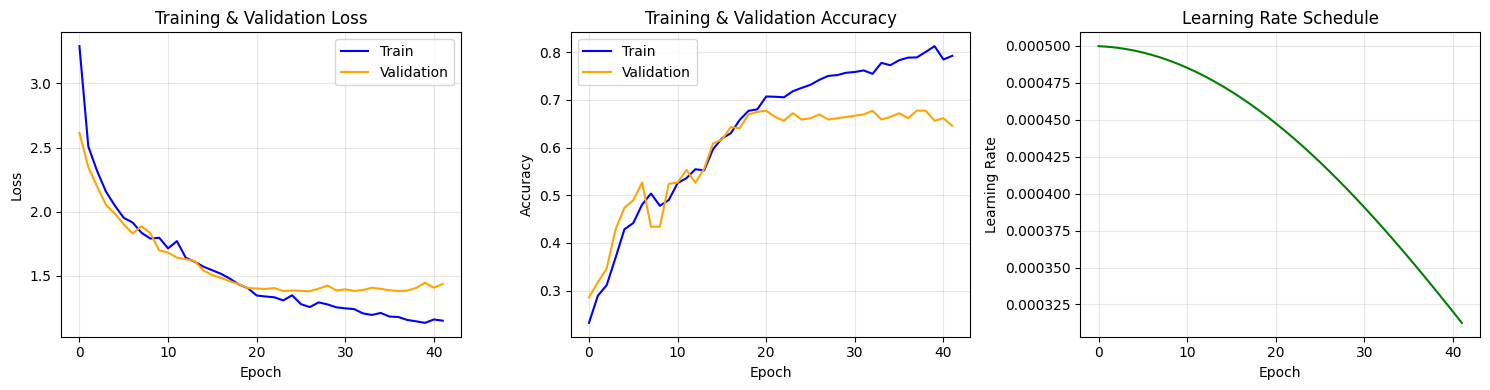

📊 Training curves saved to /content/drive/MyDrive/guitar_thesis/checkpoints/training_curves.png


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curves
axes[0].plot(history["train_loss"], label="Train", color="blue")
axes[0].plot(history["val_loss"], label="Validation", color="orange")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(history["train_acc"], label="Train", color="blue")
axes[1].plot(history["val_acc"], label="Validation", color="orange")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Training & Validation Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate
axes[2].plot(history["lr"], color="green")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Learning Rate")
axes[2].set_title("Learning Rate Schedule")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/training_curves.png", dpi=150)
plt.show()

print(f"📊 Training curves saved to {CHECKPOINT_DIR}/training_curves.png")

---
## 🎸 Cell 11: Generate Samples

In [ ]:
import random

print("🎸 GENERATED SAMPLES")
print("=" * 60)

# Test with different feature combinations
test_cases = [
    {"key": "G", "mode": "major", "genre": "folk", "emotion": "upbeat", "tempo": 110},
    {"key": "Am", "mode": "minor", "genre": "ballad", "emotion": "melancholic", "tempo": 65},
    {"key": "E", "mode": "major", "genre": "rock", "emotion": "energetic", "tempo": 140},
    {"key": "C", "mode": "major", "genre": "pop", "emotion": "hopeful", "tempo": 100},
    {"key": "D", "mode": "major", "genre": "country", "emotion": "nostalgic", "tempo": 95},
]

for i, features in enumerate(test_cases, 1):
    result = model.generate(features, temperature=0.8)
    print(f"\n{i}. {features['genre'].upper()} in {features['key']} {features['mode']} ({features['emotion']}, {features['tempo']} BPM)")
    print(f"   Chords: {' - '.join(result['chords'])}")
    print(f"   Strum:  {result['strum_pattern']}")

# Generate multiple variations for same input
print("\n" + "=" * 60)
print("🔄 VARIATIONS (same input, different outputs)")
print("=" * 60)

features = {"key": "G", "mode": "major", "genre": "folk", "emotion": "upbeat", "tempo": 110}
print(f"\nInput: {features['genre']} in {features['key']} {features['mode']}")

for i in range(5):
    result = model.generate(features, temperature=0.9)
    print(f"   {i+1}. {' - '.join(result['chords']):25s} | {result['strum_pattern']}")

🎸 GENERATED SAMPLES

1. FOLK in G major (upbeat, 110 BPM)
   Chords: A#m - D - D
   Strum:  DDU_U_D

2. BALLAD in Am minor (melancholic, 65 BPM)
   Chords: C - Am - F - Am
   Strum:  ____D__

3. ROCK in E major (energetic, 140 BPM)
   Chords: E - E - A - A
   Strum:  DDDDDDDD

4. POP in C major (hopeful, 100 BPM)
   Chords: C - G - F - Am
   Strum:  D_DU_DU

5. COUNTRY in D major (nostalgic, 95 BPM)
   Chords: D - F#m - F#m
   Strum:  D_DU_DUU_

🔄 VARIATIONS (same input, different outputs)

Input: folk in G major
   1. G - D - C - C             | DU_DU__
   2. G - F - D - D - C         | 
   3. G - G - Bm                | DDU___
   4. G - Em - C - D            | D_DU_DU
   5. D - Em - D                | DUDU


---
## 💾 Cell 12: Save Final Model

In [ ]:
# Save final model with all information
final_checkpoint = {
    "model_state_dict": model.state_dict(),
    "history": dict(history),
    "config": CONFIG,
    "best_val_loss": best_val_loss,
    "vocab_size": VOCAB_SIZE,
    "max_seq_length": MAX_SEQ_LENGTH,
}

final_path = f"{CHECKPOINT_DIR}/guitar_lstm_final.pt"
torch.save(final_checkpoint, final_path)

print(f"💾 Final model saved to: {final_path}")
print(f"   File size: {os.path.getsize(final_path) / 1e6:.2f} MB")

# Save history as JSON
history_path = f"{CHECKPOINT_DIR}/training_history.json"
with open(history_path, 'w') as f:
    json.dump(dict(history), f, indent=2)
print(f"📊 Training history saved to: {history_path}")

💾 Final model saved to: /content/drive/MyDrive/guitar_thesis/checkpoints/guitar_lstm_final.pt
   File size: 4.34 MB
📊 Training history saved to: /content/drive/MyDrive/guitar_thesis/checkpoints/training_history.json


---
## 📥 Cell 13: Download Results (Optional)

Download the trained model and results to your local machine.

In [ ]:
from google.colab import files

print("📥 Files available for download:")
print(f"   1. {CHECKPOINT_DIR}/best_model.pt")
print(f"   2. {CHECKPOINT_DIR}/guitar_lstm_final.pt")
print(f"   3. {CHECKPOINT_DIR}/training_history.json")
print(f"   4. {CHECKPOINT_DIR}/training_curves.png")

# Uncomment to download:
# files.download(f"{CHECKPOINT_DIR}/best_model.pt")
# files.download(f"{CHECKPOINT_DIR}/training_history.json")
# files.download(f"{CHECKPOINT_DIR}/training_curves.png")

📥 Files available for download:
   1. /content/drive/MyDrive/guitar_thesis/checkpoints/best_model.pt
   2. /content/drive/MyDrive/guitar_thesis/checkpoints/guitar_lstm_final.pt
   3. /content/drive/MyDrive/guitar_thesis/checkpoints/training_history.json
   4. /content/drive/MyDrive/guitar_thesis/checkpoints/training_curves.png


---
## 🎉 Training Complete!

**What you've accomplished:**
- ✅ Trained an LSTM model (~1.08M parameters)
- ✅ Used teacher forcing with cross-entropy loss
- ✅ Implemented early stopping to prevent overfitting
- ✅ Generated guitar patterns conditioned on musical features
- ✅ Saved checkpoints to Google Drive

**Next Steps:**
1. Evaluate the model on the test set (Chat 10)
2. Compare with the Transformer model (Chat 7 continued)
3. Build the conversational interface (Chat 9)

---

**Author:** Rohan Rajendra Dhanawade  
**Thesis Supervisor:** Prof. Dr. Alexander I. Iliev  
**University:** SRH Berlin University of Applied Sciences